# Purpose: 

- Scraping from OpenSecrets.org to get lobbying data

In [14]:
# Preabmle/Loading packages:

import requests
import pandas as pd
from bs4 import BeautifulSoup
import os 
import re
import time
from datetime import datetime 
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Making sure we're in the right directory 
os.getcwd()

## repeated printouts and wide-format text:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', 100)


### Defining functions for web scraping

In [7]:


def getting_sponsor_info(sp):
    """Input: 
    - Beautiful Soup of HTML request 
    Output: Sponsor/co-sponsor information of specified bill """

    try:
        # Find all elements with the class "component-wrap"
        component_wrap_elements = sp.find_all('div', class_='component-wrap')
        component_wrap = component_wrap_elements[1]
        ul = component_wrap.find_all('ul')

        ul1 = ul[0]
        sponsor = ul1.text[2:]
        sponsor = sponsor.replace('\n', '')

        ul2 = ul[1]
        cosponsor = ul2.text[2:]
        cosponsor = cosponsor.replace('•', ',').replace('\n', '')

        return sponsor, cosponsor
    
    # Catching exceptions 
    except Exception as e:
        print("An error occurred:", e)
        return "", ""

In [8]:
def getting_lobby_firm_info(sp):
    try:
        rows = sp.find_all('tr')
        organizations = []
        years = []
        issue_counts = []
        issue_links = []

        for row in rows:
            columns = row.find_all('td')
            # Check if there are three columns in the row
            if len(columns) > 0:
                organization = columns[0].text.strip()
                year = columns[1].text.strip()
                issue_count = columns[2].text.strip()
                issue_link_tag = columns[2].find('a')
                issue_link = issue_link_tag['href']

                organizations.append(organization)
                years.append(year)
                issue_counts.append(issue_count)
                issue_links.append(issue_link)

        return organizations, years, issue_counts, issue_links
    except Exception as e:
        print("An error occurred:", e)
        return [], [], [], []


In [ ]:
## Testing functions: 

# url = "https://www.opensecrets.org/federal-lobbying/bills/sponsors?cycle=2021&id=hr5871-112"
# respo = requests.get(url)
# soup = BeautifulSoup(respo.text, 'html.parser')
# spon, co_spon = getting_sponsor_info(soup)

# url = "https://www.opensecrets.org/federal-lobbying/bills/summary?cycle=2021&id=hr5871-112"
# respo = requests.get(url)
# soup = BeautifulSoup(respo.text, 'html.parser')
# organizations, years, issue_counts, issue_links = getting_lobby_firm_info(soup)


In [4]:
# Loading file of bill names: 
with open("bill_list.txt", 'r') as file:

    # Reading the lines from the file and remove any leading or trailing whitespace
    loaded_list = [line.strip() for line in file]

# Getting some base characteristics 
len(loaded_list)
loaded_list[:2]

11061

['hconres1', 'hconres10']

In [11]:

# Initiating empty list to store all data 
data_list = []

# For all bills:
for x in tqdm(loaded_list):

    # Getting key (which is just bill_id-118: where 118 refers to the 118th Congress)
    key = x + "-118" 

    # Scraping:
    base_url = "https://www.opensecrets.org/federal-lobbying/bills/summary?id=" 
    base_lnk_url = base_url + key
    respo = requests.get(base_lnk_url)
    soup = BeautifulSoup(respo.text, 'html.parser')
    
    # Define a regular expression pattern to match the desired text
    pattern = r"<h2>Clients Lobbying on (.+)</h2>"
    # Use re.search to find the pattern in the HTML
    match = re.search(pattern, str(soup))
    if match:
        bill_title = match.group(1)
    else:
        bill_title = ""

    if len(soup.find_all('td')) > 1:
        # print(getting_sponsor_info(soup))
        url = "https://www.opensecrets.org/federal-lobbying/bills/sponsors?id=" + key
        respo = requests.get(url)
        soup = BeautifulSoup(respo.text, 'html.parser')

        # Using predefined functions to get relavant information: 
        spon, co_spon = getting_sponsor_info(soup)
        organizations, years, issue_counts, issue_links = getting_lobby_firm_info(soup)

        for i in range(len(organizations)):
            data_list.append({'ID': key,
                    'Bill_Title' : bill_title,
                'Sponsor': spon,
                'Co_Sponsors' : co_spon, 
                'Organization': organizations[i],
                'Year': years[i],
                'Issue_Count': issue_counts[i],
                'Issue_Link': issue_links[i]})

# Create a DataFrame from the list of dictionaries
res = pd.DataFrame(data_list)

  0%|          | 0/11061 [00:00<?, ?it/s]

An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error oc

In [18]:
def getting_issues_text(url_extension):

    """Input: URL Extension 
    Output: Text of issues reported/cited by organizations when lobbying
    """

    url = "https://www.opensecrets.org" + url_extension
    respo = requests.get(url)
    soup = BeautifulSoup(respo.text, 'html.parser')
    # Extract the data from the table
    table = soup.find('table', class_='DataTable-Partial')
    if table:
        # Extract the rows from the table
        rows = table.find_all('tr')
        # Initialize a list to store the data
        data_list = []
    # Iterate through the rows and extract the data
        for row in rows:
            cols = row.find_all('td')
            if len(cols) == 2:
                report = cols[0].get_text(strip=True)
                content = cols[1].get_text(strip=True)
                data_list.append((report, content))

        data = '\n'.join([f"{item[0]} {item[1]}" for item in data_list])
        data = data.replace("\n", " ").replace("\ ", " ").replace("/", " ")
    else:
        data = " " 
    return data

In [ ]:
# Running function:
res["issues_text"] = [getting_issues_text(ext) for ext in tqdm(res["Issue_Link"])]

# Getting issues text length
res["issue_text_len"] = [len(x.split(" ")) for x in res["issues_text"]]

In [17]:
# Saving as CSV: 
res.to_csv("C:\\Users\\Sanha Tahir\\Downloads\\GeorgeTown\\DS3\\Final Project\\lobbying_results3_with_text.csv")

### Exploratory Visualization:

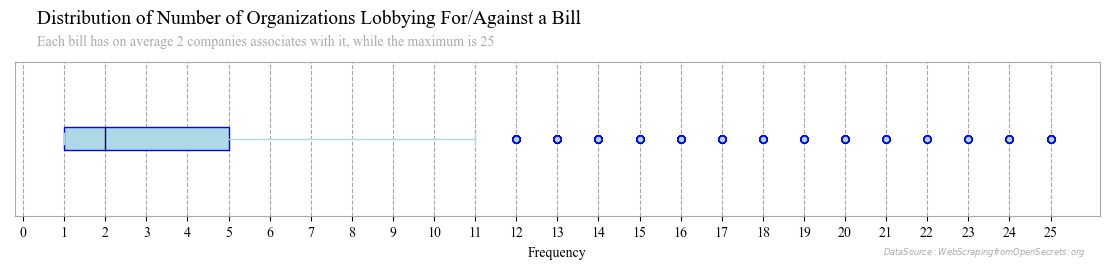

In [194]:
# # Create a boxplot with no outline and a blue background

fig, ax = plt.subplots(figsize=(14, 2)) 
boxplot = ax.boxplot(result["Organization"], vert=False, patch_artist=True, 
boxprops={'facecolor': 'lightblue', 'edgecolor': 'blue'}, 
medianprops={'color': 'darkblue'},
                     whiskerprops={'color': 'lightblue'}, capprops={'color': 'lightblue'})


# Customize the color of the outlier boxes
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markeredgecolor='blue', markerfacecolor='lightblue')


ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('darkgrey')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('darkgrey')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('darkgrey')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('darkgrey')



title_string = 'Distribution of Number of Organizations Lobbying For/Against a Bill'
subtitle_string = 'Each bill has on average 2 companies associates with it, while the maximum is 25'
ax.text(0.02, 1.25, title_string, transform=ax.transAxes, fontsize=14)

ax.set_title(subtitle_string, x=0.02, y=1.05, ha='left', fontsize= 10, color='darkgrey')

ax.text(0.8, -0.25, "$\it{Data Source: Web Scraping from OpenSecrets.org}$", transform=ax.transAxes, fontsize=6, color='darkgrey')

# # Customize plot labels and title
# ax.set_title('Boxplot with Blue Background')
# ax.set_xlabel('Data Values')
plt.yticks([])
x_ticks = np.arange(26)
ax.set_xticks(x_ticks)
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)

plt.rcParams["font.family"] = "Times New Roman"

plt.xlabel("Frequency")

plt.show();


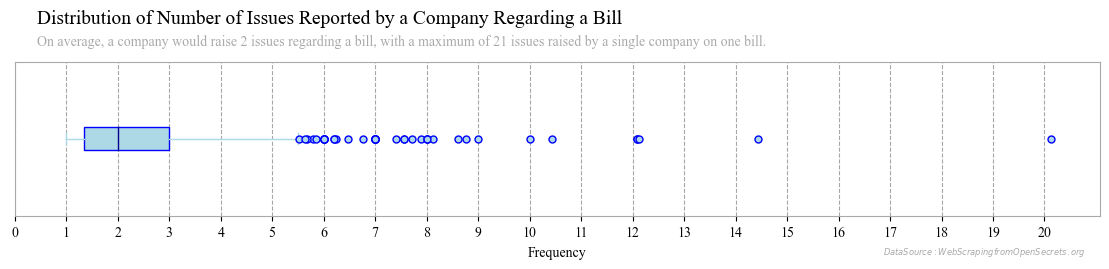

In [193]:

# # Create a boxplot with no outline and a blue background

fig, ax = plt.subplots(figsize=(14, 2)) 
boxplot = ax.boxplot(result["Issue_Count"], vert=False, patch_artist=True, 
boxprops={'facecolor': 'lightblue', 'edgecolor': 'blue'}, 
medianprops={'color': 'darkblue'},
                     whiskerprops={'color': 'lightblue'}, capprops={'color': 'lightblue'})


# Customize the color of the outlier boxes
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markeredgecolor='blue', markerfacecolor='lightblue')


ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('darkgrey')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('darkgrey')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('darkgrey')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('darkgrey')



title_string = 'Distribution of Number of Issues Reported by a Company Regarding a Bill'
subtitle_string = 'On average, a company would raise 2 issues regarding a bill, with a maximum of 21 issues raised by a single company on one bill.'
ax.text(0.02, 1.25, title_string, transform=ax.transAxes, fontsize=14)

ax.set_title(subtitle_string, x=0.02, y=1.05, ha='left', fontsize= 10, color='darkgrey')

ax.text(0.8, -0.25, "$\it{Data Source: Web Scraping from OpenSecrets.org}$", transform=ax.transAxes, fontsize=6, color='darkgrey')

# # Customize plot labels and title
# ax.set_title('Boxplot with Blue Background')
# ax.set_xlabel('Data Values')
plt.yticks([])

x_ticks = np.arange(21)
ax.set_xticks(x_ticks)

# x_ticks = np.linspace(0, 25, 1)
# # ax.set_xticks(x_ticks)
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)

plt.rcParams["font.family"] = "Times New Roman"

plt.xlabel("Frequency")
plt.show();


In [186]:
res.head()
res["issue_text_len"] = [len(x.split(" ")) for x in res["issues_text"]]

,ID,Bill_Title,Sponsor,Co_Sponsors,Organization,Year,Issue_Count,Issue_Link,issues_text
0,hr5871-109,H.R.5871: Mathematics and Science Teaching Corps Act of 2006,Jim Saxton (R-NJ),"Sherwood Boehlert (R-NY), Vernon J Ehlers (R-MI), Harold E Ford Jr (D-TN), Ruben Hinojosa (D-TX...",American Federation of Teachers,2006,1,/federal-lobbying/bills/specific_issues?client_id=D000000083&cycle=2006&id=hr5871-109,NCLB: all bills relating S 3714 HR 2248 Math and Science Teaching Corps of '06 HR 609 College A...
1,hr5871-109,H.R.5871: Mathematics and Science Teaching Corps Act of 2006,Jim Saxton (R-NJ),"Sherwood Boehlert (R-NY), Vernon J Ehlers (R-MI), Harold E Ford Jr (D-TN), Ruben Hinojosa (D-TX...",Visa Inc,2006,1,/federal-lobbying/bills/specific_issues?client_id=D000029689&cycle=2006&id=hr5871-109,S.3902 : A bill to provide for education competitiveness. S.3909 : A bill to amend the foreign ...
2,hr5871-112,H.R.5871: A Plus Act,Karen Bass (D-CA),"Robert E Andrews (D-NJ), Michele Bachmann (R-MN), Andre Carson (D-IN), David Cicilline (D-RI), ...",Children's Defense Fund,2012,2,/federal-lobbying/bills/specific_issues?client_id=D000032536&cycle=2012&id=hr5871-112,Family Educational Rights and Privacy Act (Uninterrupted Scholars Act S. 3472 and A Plus Act (H...
3,hr5871-112,H.R.5871: A Plus Act,Karen Bass (D-CA),"Robert E Andrews (D-NJ), Michele Bachmann (R-MN), Andre Carson (D-IN), David Cicilline (D-RI), ...",County Welfare Directors Assn of Calif,2012,1,/federal-lobbying/bills/specific_issues?client_id=D000049813&cycle=2012&id=hr5871-112,"Foster Care, Title IV of Social Security Act TANF Reauthorization SNAP Reauthorization Uninterr..."
4,hr5871-112,H.R.5871: A Plus Act,Karen Bass (D-CA),"Robert E Andrews (D-NJ), Michele Bachmann (R-MN), Andre Carson (D-IN), David Cicilline (D-RI), ...",American Bar Assn,2012,1,/federal-lobbying/bills/specific_issues?client_id=D000043801&cycle=2012&id=hr5871-112,"S. 3478, the Uninterrupted Scholars Act H.R. 5871, Access to Papers Leads to Uninterrupted Scho..."


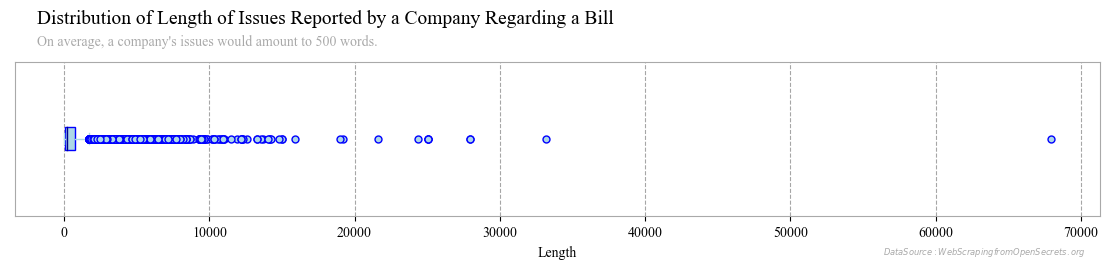

In [259]:

# # Create a boxplot with no outline and a blue background

fig, ax = plt.subplots(figsize=(14, 2)) 
boxplot = ax.boxplot(res["issue_text_len"], vert=False, patch_artist=True, 
boxprops={'facecolor': 'lightblue', 'edgecolor': 'blue'}, 
medianprops={'color': 'darkblue'},
                     whiskerprops={'color': 'lightblue'}, capprops={'color': 'lightblue'})


# Customize the color of the outlier boxes
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markeredgecolor='blue', markerfacecolor='lightblue')


ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('darkgrey')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('darkgrey')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('darkgrey')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('darkgrey')



title_string = 'Distribution of Length of Issues Reported by a Company Regarding a Bill'
subtitle_string = "On average, a company's issues would amount to 500 words."
ax.text(0.02, 1.25, title_string, transform=ax.transAxes, fontsize=14)

ax.set_title(subtitle_string, x=0.02, y=1.05, ha='left', fontsize= 10, color='darkgrey')

ax.text(0.8, -0.25, "$\it{Data Source: Web Scraping from OpenSecrets.org}$", transform=ax.transAxes, fontsize=6, color='darkgrey')

# # Customize plot labels and title
# ax.set_title('Boxplot with Blue Background')
# ax.set_xlabel('Data Values')
plt.yticks([])

# x_ticks = np.linspace(0, 25, 1)
# # ax.set_xticks(x_ticks)
plt.grid(True, axis='x', linestyle='--', color='gray', alpha=0.7)

plt.rcParams["font.family"] = "Times New Roman"

plt.xlabel("Length")
plt.show();


Text(-0.1, 3, 'Correlation Between Length of Issues Text and Number of Issues')

Text(-0.01, 1.05, 'No consistent relationship between issue counts and text.')

Text(0.2, -0.1, '$\\it{Data Source: Web Scraping from OpenSecrets.org}$')

<AxesSubplot:title={'center':'No consistent relationship between issue counts and text.'}, xlabel='Issue_Count', ylabel='issue_text_len'>

Text(0.5, 0, 'Count of Issues')

Text(0, 0.5, 'Length of Issues Text')

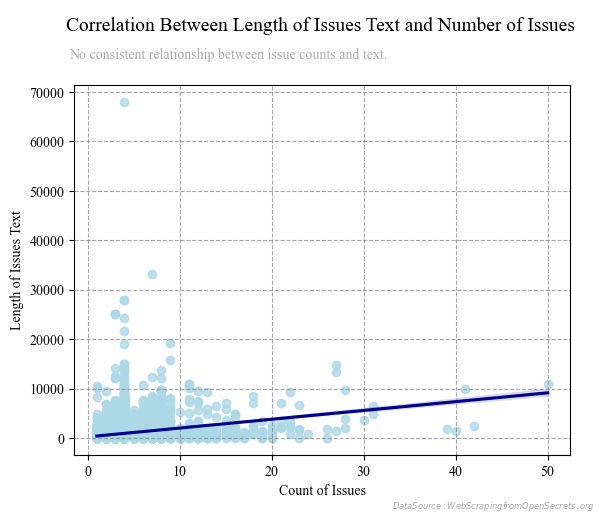

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
x = res["Issue_Count"]
y = res["issue_text_len"]

title_string = 'Correlation Between Length of Issues Text and Number of Issues'
subtitle_string = 'No consistent relationship between issue counts and text.'

plt.text(-0.1, 3, title_string, transform=ax.transAxes, fontsize=14)
plt.title(subtitle_string, x=-0.01, y=1.05, ha='left', fontsize=10, color='darkgrey')
plt.text(0.2, -0.1, "$\it{Data Source: Web Scraping from OpenSecrets.org}$", transform=ax.transAxes, fontsize=6, color='darkgrey')

# Fit a linear regression model and plot the regression line with a 95% CI
sns.regplot(x=x, y=y, ci=95, color='darkblue', line_kws={'color': 'darkblue'}, scatter_kws={'color': 'lightblue'})

plt.xlabel("Count of Issues")
plt.ylabel("Length of Issues Text")

plt.grid(linestyle='--', color='gray', alpha=0.7)
plt.show()


Text(0.5, 0, 'Issue_Count')

Text(0, 0.5, 'issue_text_len')

Text(-0.1, 3, 'Distribution of Number of Issues Reported by a Company Regarding a Bill')

Text(-0.01, 1.05, 'On average, a company would raise 2 issues regarding a bill.')

Text(0.2, -0.1, '$\\it{Data Source: Web Scraping from OpenSecrets.org}$')

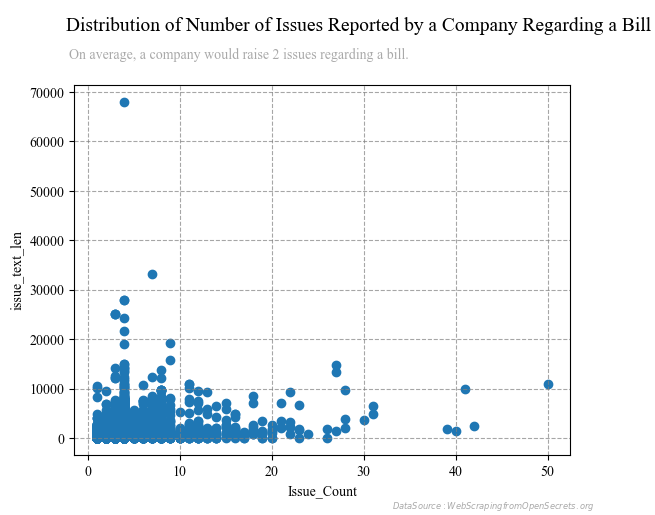

In [251]:
plt.scatter( x = res["Issue_Count"], y = res["issue_text_len"])
plt.xlabel("Issue_Count")
plt.ylabel("issue_text_len")

title_string = 'Distribution of Number of Issues Reported by a Company Regarding a Bill'
subtitle_string = 'On average, a company would raise 2 issues regarding a bill.'

plt.text(-0.1, 3, title_string, transform=ax.transAxes, fontsize=14)

plt.title(subtitle_string, x= -0.01, y=1.05, ha='left', fontsize= 10, color='darkgrey')


plt.text(0.2, -0.1, "$\it{Data Source: Web Scraping from OpenSecrets.org}$", transform=ax.transAxes, fontsize=6, color='darkgrey')

plt.grid(linestyle='--', color='gray', alpha=0.7)
plt.show()